# Investigate simulations with individual soil column per pft  

Inlcuding regridding

(c) Inne Vanderkelen - October 2023

## 1. Settings

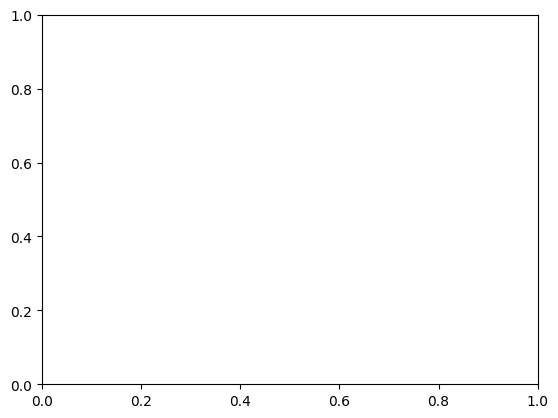

In [2]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 
import pandas as pd

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [3]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [4]:
# case settings

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc" ] #"SOILPSI", "FPSN","QHR","SMP","GSSHA","GSSUN"

# discard 2004 until 2008 as spin up years
start_year, end_year = 1990, 2014 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-31")

In [5]:
## settings for plotting
ds_ctl =  load_case_ctl(['H2OSOI'])

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

regions_sand_clay = [6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

plotting_depth = 2 # m 8
figsize = (17,38)

In [6]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]
pft_list_grassland = [0,12,13,14]

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [7]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [8]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

In [9]:
# get masks for sandy and clay soils

# define tresholds for pct sand and pct clay
pct_sand_threshold_min = 60
pct_sand_threshold_max = 85
pct_clay_threshold = 40
da_sand_mask, da_clay_mask = get_texture_masks(pct_sand_threshold_max,pct_sand_threshold_min,  pct_clay_threshold, ds_input, levsoi_thickness)

In [10]:
# wilting point
# load precalculated wilting point datasets
da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

In [11]:
# growing season mask
da_growingseason_mask = xr.open_dataset(procdir+'growing_season_mask.nc')['GS_MASK']

## Look at WB variables for cropland

In [21]:
ds_delta_timmean, ds_ctl_timmean = calc_timmean_pft(pft_list, variables, case_ctl, stream, start_year, end_year)

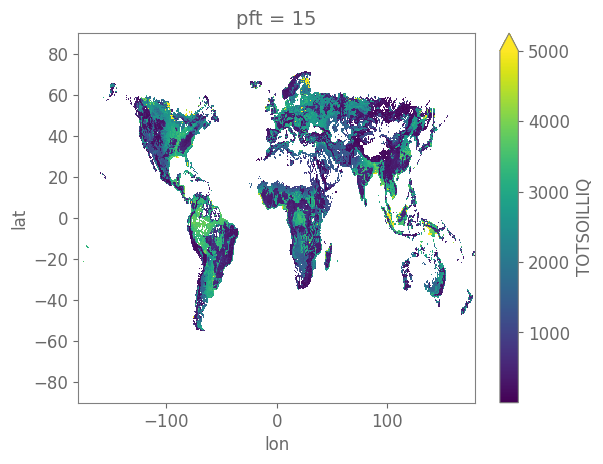

In [29]:
ds_ctl_timmean.sel(pft=15)['TOTSOILLIQ'].plot(vmax = 5000)

In [45]:

# calculate and save the time mean for different pfts
def calc_timmean_pft(pft_list, variables, case_ctl, stream, start_year, end_year):

    for i,variable in enumerate(variables): 

        filename_delta_timmean  = procdir+'postprocessing/timmean/'+variable+'.'+case_ctl+'_delta.pfts.'+stream+'.'+str(start_year)+"-"+str(end_year)+"_timmean.nc"
        filename_ctl_timmean = procdir+'postprocessing/timmean/'+variable+'.'+case_ctl+'.pfts'+'.'+stream+'.'+str(start_year)+"-"+str(end_year)+"_timmean.nc"

            

        if not os.path.exists(filename_delta_timmean) or not os.path.exists(filename_ctl_timmean): 

            print(variable)
            
            if variable == "QIRRIG_FROM_SURFACE": 
                pft_list_corrected = [16]
            else: 
                pft_list_corrected = pft_list.remove(16)


            da_delta, da_delta_rel = calc_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list)

            list_da_pft = []

            for pft_int in pft_list_corrected: 

                list_da_pft.append(load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable))

            da_ctl = xr.concat(list_da_pft, dim='ivt_str').rename({'ivt_str':'pft'})
            da_ctl['pft'] = pft_list_corrected

            da_delta_timmean = da_delta.mean('time')
            da_ctl_timmean = da_ctl.mean('time')


            da_delta_timmean.to_dataset(name=variable).compute().to_netcdf(filename_delta_timmean)
            da_ctl_timmean.to_dataset(name=variable).compute().to_netcdf(filename_ctl_timmean)
        
        else: 

            da_delta_timmean = xr.open_dataset(filename_delta_timmean)[variable]
            da_ctl_timmean = xr.open_dataset(filename_ctl_timmean)[variable]

            
        if i ==0: 
            ds_delta_timmean = da_delta_timmean.to_dataset(name=variable)
            ds_ctl_timmean = da_ctl_timmean.to_dataset(name=variable)
        else: 
            ds_delta_timmean[variable] = da_delta_timmean
            ds_ctl_timmean[variable] = da_ctl_timmean

    return ds_delta_timmean, ds_ctl_timmean

In [46]:
%%time 
# List of variables to import from file(s) in $indir matching $pattern.
variables = ["TOTSOILLIQ","QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',"QVEGE", "QVEGT","QSOIL","TG", "QIRRIG_FROM_SURFACE"  ] #"SOILPSI", "FPSN","QHR","SMP","GSSHA","GSSUN"

pft_list = pft_list_crops

ds_delta_timmean, ds_ctl_timmean = calc_timmean_pft(pft_list, variables, case_ctl, stream, start_year, end_year)


CPU times: user 114 ms, sys: 8.12 ms, total: 122 ms
Wall time: 120 ms


In [47]:
%%time 

flag_calc_wb = False

if flag_calc_wb:


    pft_list = pft_list_crops

    variables_wb = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'EFLX_LH_TOT',   "QVEGE", "QVEGT","QSOIL", 'QIRRIG_FROM_SURFACE']
    variables_wb = ['TSA']

    variables_wb_toplot = ['QDRAI', 'QINFL', 'QOVER', 'SOILLIQ', 'ET',  "QVEGE", "QVEGT","QSOIL",  'QIRRIG_FROM_SURFACE']

    d_wb_vars = {}


    for pft_int in pft_list: 
        for i,region in enumerate(region_ids):
            print(region)

            region_name = regionmask.defined_regions.ar6.land[region].name
            region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

            d_var_list = {}

            for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
                print(variable)


                da_delta, da_delta_rel = calc_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list)
                list_da_pft = []

                for pft_int in pft_list: 

                    list_da_pft.append(load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable))

                da_ctl = xr.concat(list_da_pft, dim='ivt_str').rename({'ivt_str':'pft'})
                da_ctl['pft'] = pft_list

                mask = regionmask.defined_regions.ar6.land.mask(da_delta)

                da_delta_timmean = (da_delta).mean('time').where(texture_mask) 
                da_ctl_timmean = da_ctl.mean('time').where(texture_mask)

                da_ctl_seasmean_region = (da_delta_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon')) / da_ctl_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon'))).values*100

                d_var_list[variable_toplot]= da_ctl_seasmean_region

            d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

            df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
            #df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'.nc')

else: 
    d_wbterms = {}
    for pft_int in pft_list: 
        d_wbterms[pft_int] = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'.nc', index_col=0)
    

NameError: name 'texture_name' is not defined

In [48]:
%%time 

flag_calc_wb = True

texture_mask = da_sand_mask.compute()

pft_list = pft_list_crops

variables_wb = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'EFLX_LH_TOT',   "QVEGE", "QVEGT","QSOIL", "QIRRIG_FROM_SURFACE"]
variables_wb_toplot = ['QDRAI', 'QINFL', 'QOVER', 'SOILLIQ', 'ET',  "QVEGE", "QVEGT","QSOIL", "QIRRIG_FROM_SURFACE"]

def calc_wb_terms_pft(variables_wb, variables_wb_toplot, pft_list, case_ctl, stream, start_year, end_year, texture_name=False, texture_mask=False, flag_calc_wb=True): 
    d_wbterms = {}
    if flag_calc_wb:
        
        d_wb_vars = {}

        ds_delta_timmean, ds_ctl_timmean = calc_timmean_pft(pft_list, variables_wb, case_ctl, stream, start_year, end_year)


        # when available apply texture mask
        if  not isinstance(texture_mask, bool) : 
            ds_delta_timmean = ds_delta_timmean.where(texture_mask) 
            ds_delta_timmean = ds_delta_timmean.where(texture_mask) 
        else: 
            texture_name = ''


        for pft_int in pft_list: 
            if pft_int == 15 and "QIRRIG_FROM_SURFACE" in variables_wb: 
                variables_wb = variables_wb.remove( "QIRRIG_FROM_SURFACE")
                variables_wb_toplot = variables_wb_toplot.remove("QIRRIG_FROM_SURFACE")
            for i,region in enumerate(region_ids):

                region_name = regionmask.defined_regions.ar6.land[region].name
                region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

                d_var_list = {}


                for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 

                    da_delta_timmean = ds_delta_timmean[variable]
                    da_ctl_timmean = ds_ctl_timmean[variable]

                    mask = regionmask.defined_regions.ar6.land.mask(da_delta_timmean)

                    da_ctl_seasmean_region = (da_delta_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon')) / da_ctl_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon'))).values*100

                    d_var_list[variable_toplot]= da_ctl_seasmean_region

                d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

                df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
                df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'.nc')
            d_wbterms[pft_int] = df_wbterms
    else: 
        for pft_int in pft_list: 
            d_wbterms[pft_int] = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'.nc', index_col=0)
    return d_wbterms


CPU times: user 34.8 ms, sys: 7.85 ms, total: 42.6 ms
Wall time: 34.7 ms


In [49]:
pft_int = 15

d_wbterms = calc_wb_terms_pft(variables_wb, variables_wb_toplot, pft_list, case_ctl, stream, start_year, end_year, flag_calc_wb=True)
df_wbterms = d_wbterms[pft_int]

figsize = (20,30)

fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb_toplot = ['QDRAI', 'QINFL', 'QOVER', 'SOILLIQ', 'ET',  "QVEGE", "QVEGT","QSOIL"]

variables_wb = list(df_wbterms.index)
x = np.arange(1,len(variables_wb_toplot)+1,1)

for i,region in enumerate(region_ids):
    
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    df_wbterms.loc[variables_wb_toplot, str(region)].plot.bar(ax=ax, legend=False)
    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')

    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

TypeError: 'NoneType' object is not iterable

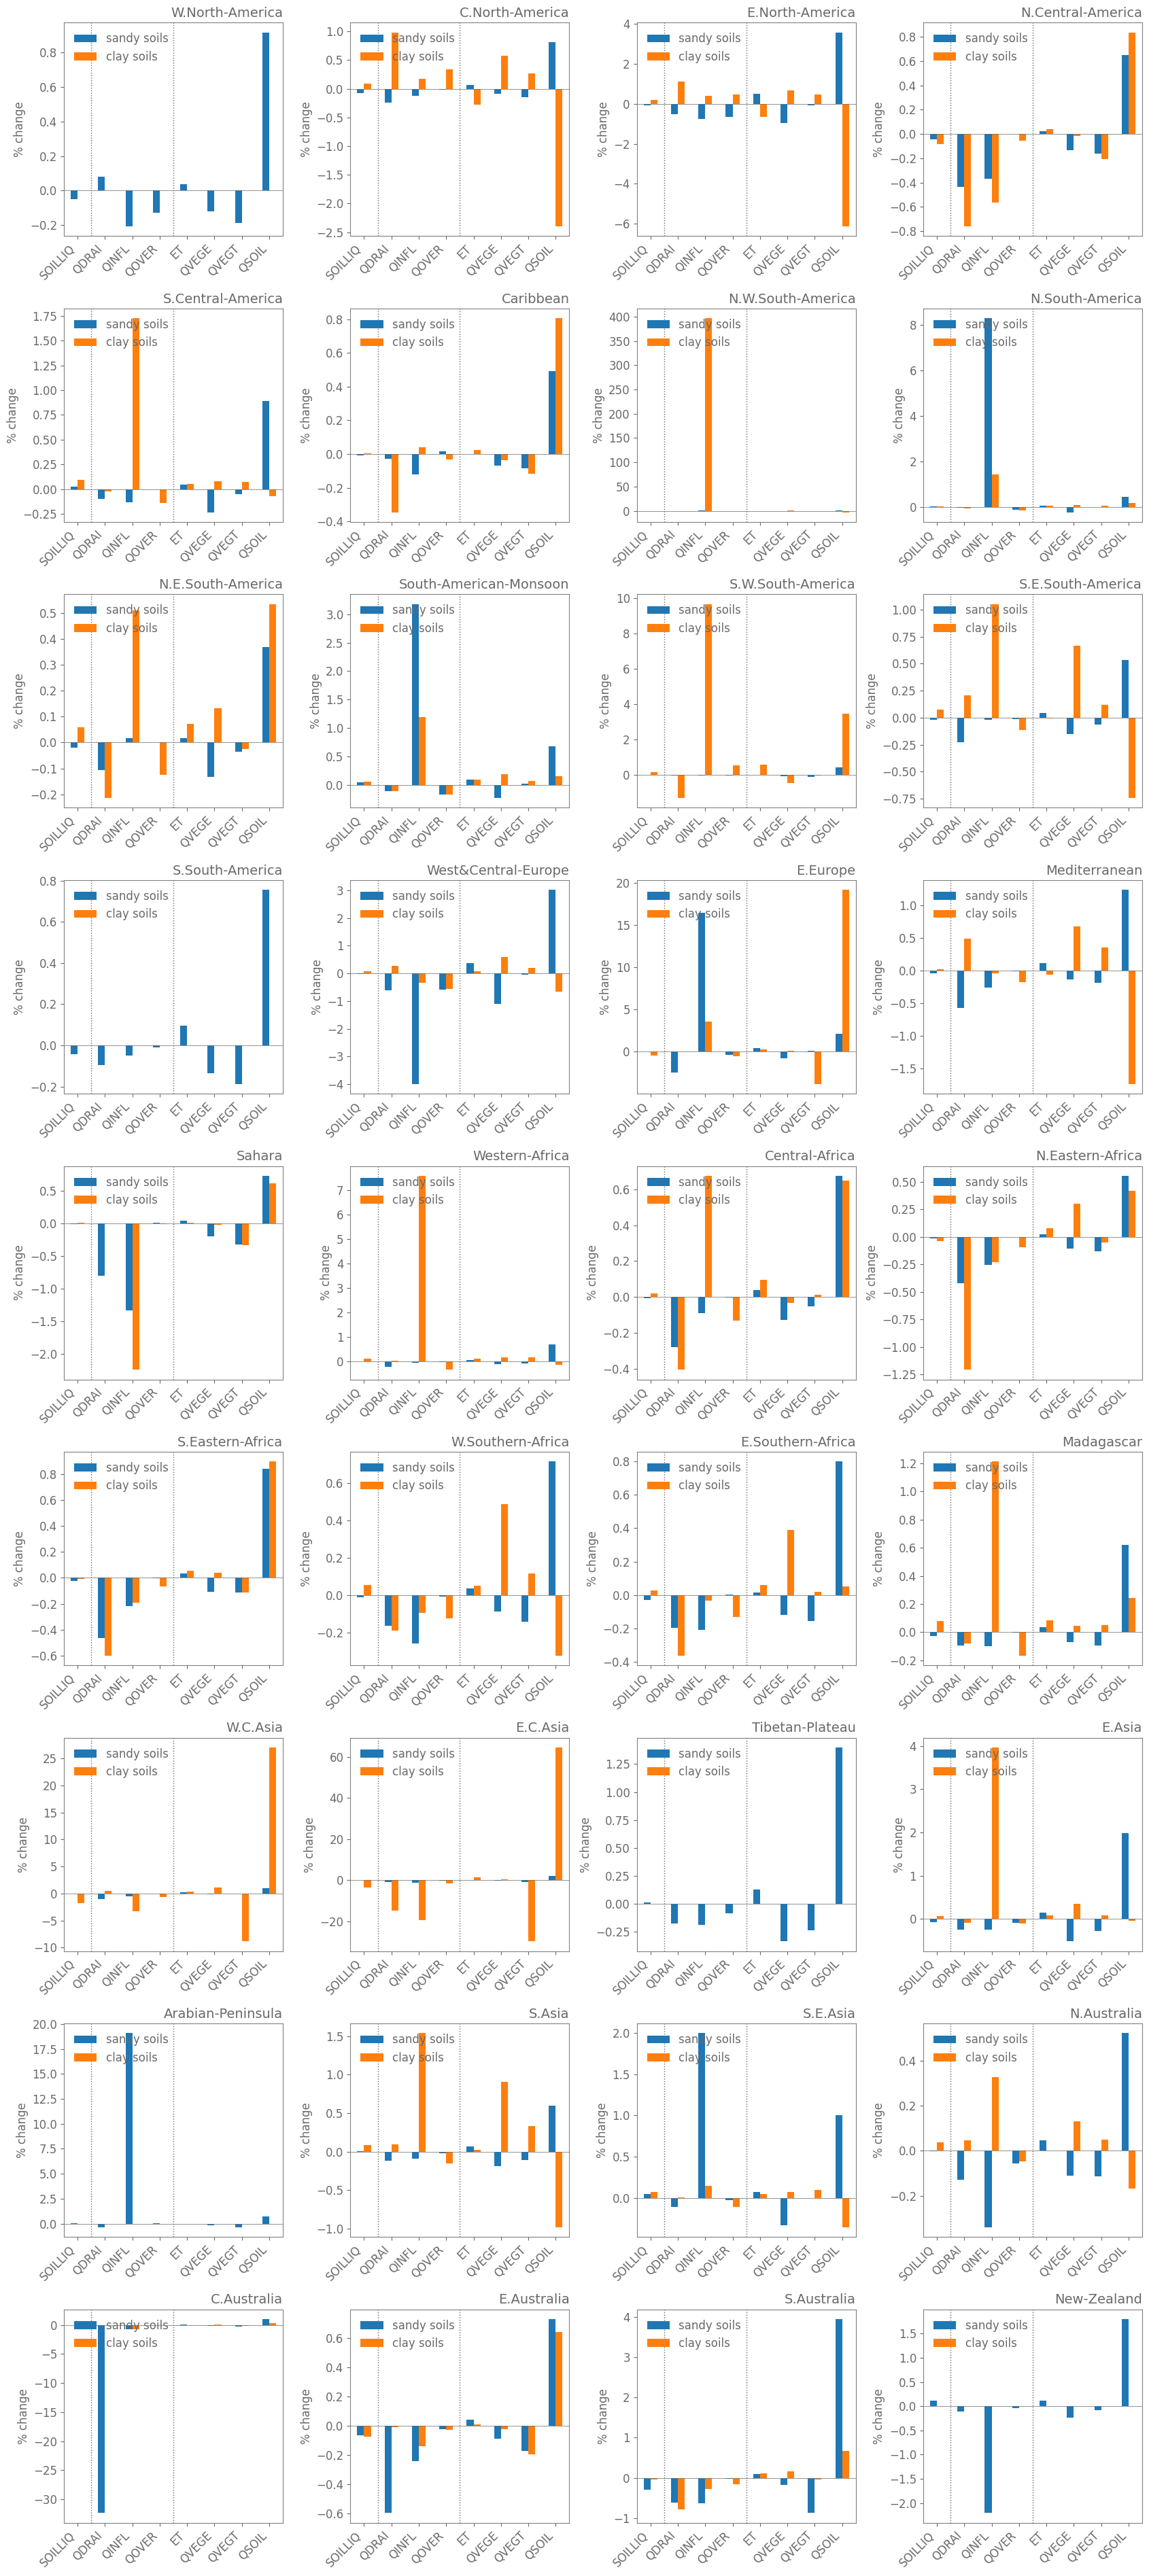

In [50]:
variables_wb        = ['TOTSOILLIQ','QDRAI' , 'QINFL', 'QOVER',  'EFLX_LH_TOT', "QVEGE", "QVEGT","QSOIL"]
variables_wb_toplot = ['SOILLIQ'   , 'QDRAI', 'QINFL', 'QOVER',     'ET'         , "QVEGE", "QVEGT","QSOIL"]


pft_int = pft_list_crops[0]
texture_mask = da_sand_mask.compute()
df_wbterms_sand = calc_wb_terms_pft(variables_wb, variables_wb_toplot, pft_list, case_ctl, stream, start_year, end_year, texture_mask.name, texture_mask, flag_calc_wb=True)[pft_int]
texture_mask = da_clay_mask.compute()
df_wbterms_clay = calc_wb_terms_pft(variables_wb, variables_wb_toplot, pft_list, case_ctl, stream, start_year, end_year, texture_mask.name, texture_mask, flag_calc_wb=True)[pft_int]

region_ids_sand = list(map(int, df_wbterms_sand.loc[:, (df_wbterms_sand.notna().sum()>0)].keys().values))
region_ids_clay = list(map(int, df_wbterms_clay.loc[:, (df_wbterms_clay.notna().sum()>0)].keys().values))
ids_uniques = set(region_ids_clay + region_ids_sand )


fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms_sand.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(ids_uniques):
    
    
    df_wbterms_toplot = pd.DataFrame(df_wbterms_sand.loc[variables_wb_toplot, str(region)]).rename(columns={str(region):'sandy soils'})
    df_wbterms_toplot['clay soils'] = df_wbterms_clay.loc[variables_wb_toplot, str(region)]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    
    df_wbterms_toplot.plot.bar(ax=ax, legend=True)

    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

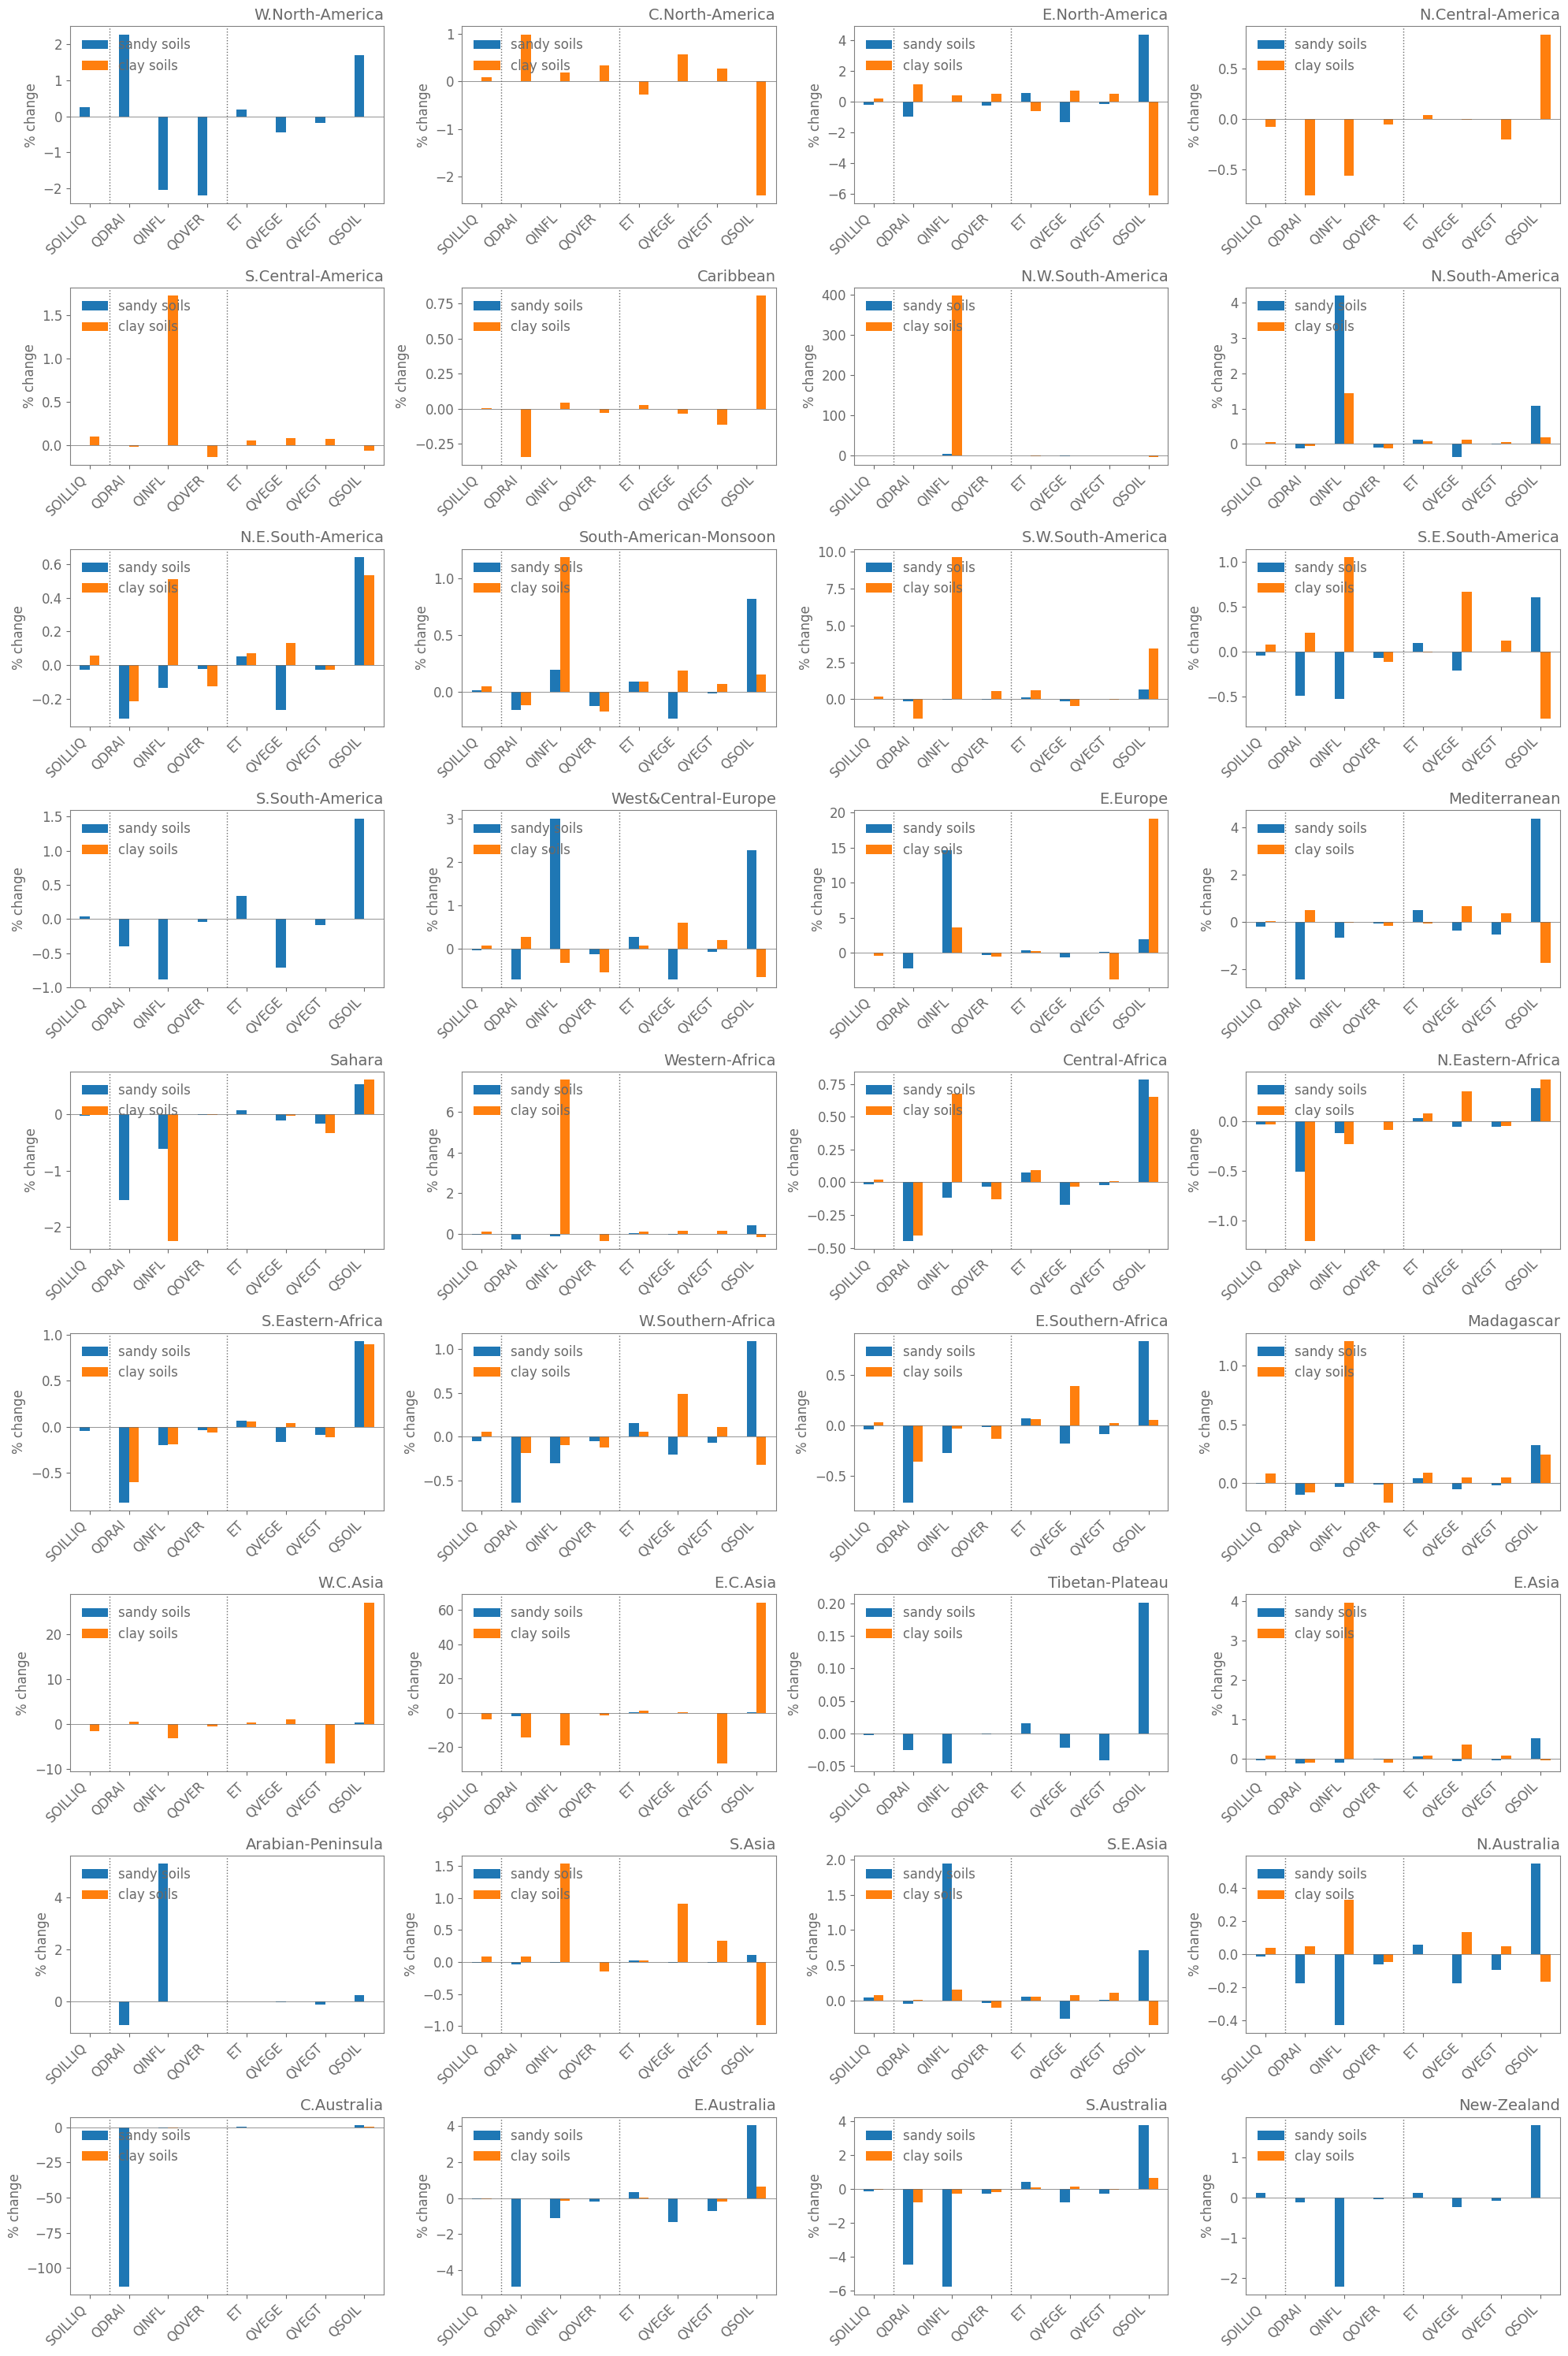

In [59]:
variables_wb        = ['TOTSOILLIQ','QDRAI' , 'QINFL', 'QOVER',  'EFLX_LH_TOT', "QVEGE", "QVEGT","QSOIL"]
variables_wb_toplot = ['SOILLIQ'   , 'QDRAI', 'QINFL', 'QOVER',     'ET'         , "QVEGE", "QVEGT","QSOIL"]


pft_int = pft_list_crops[0]
texture_mask = da_sand_mask.compute()
df_wbterms_sand = calc_wb_terms_pft(variables_wb, variables_wb_toplot, pft_list, case_ctl, stream, start_year, end_year, texture_mask.name, texture_mask, flag_calc_wb=True)[pft_int]
texture_mask = da_clay_mask.compute()
df_wbterms_clay = calc_wb_terms_pft(variables_wb, variables_wb_toplot, pft_list, case_ctl, stream, start_year, end_year, texture_mask.name, texture_mask, flag_calc_wb=True)[pft_int]

region_ids_sand = list(map(int, df_wbterms_sand.loc[:, (df_wbterms_sand.notna().sum()>0)].keys().values))
region_ids_clay = list(map(int, df_wbterms_clay.loc[:, (df_wbterms_clay.notna().sum()>0)].keys().values))
ids_uniques = set(region_ids_clay + region_ids_sand )


fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms_sand.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(ids_uniques):
    
    
    df_wbterms_toplot = pd.DataFrame(df_wbterms_sand.loc[variables_wb_toplot, str(region)]).rename(columns={str(region):'sandy soils'})
    df_wbterms_toplot['clay soils'] = df_wbterms_clay.loc[variables_wb_toplot, str(region)]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    
    df_wbterms_toplot.plot.bar(ax=ax, legend=True)

    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

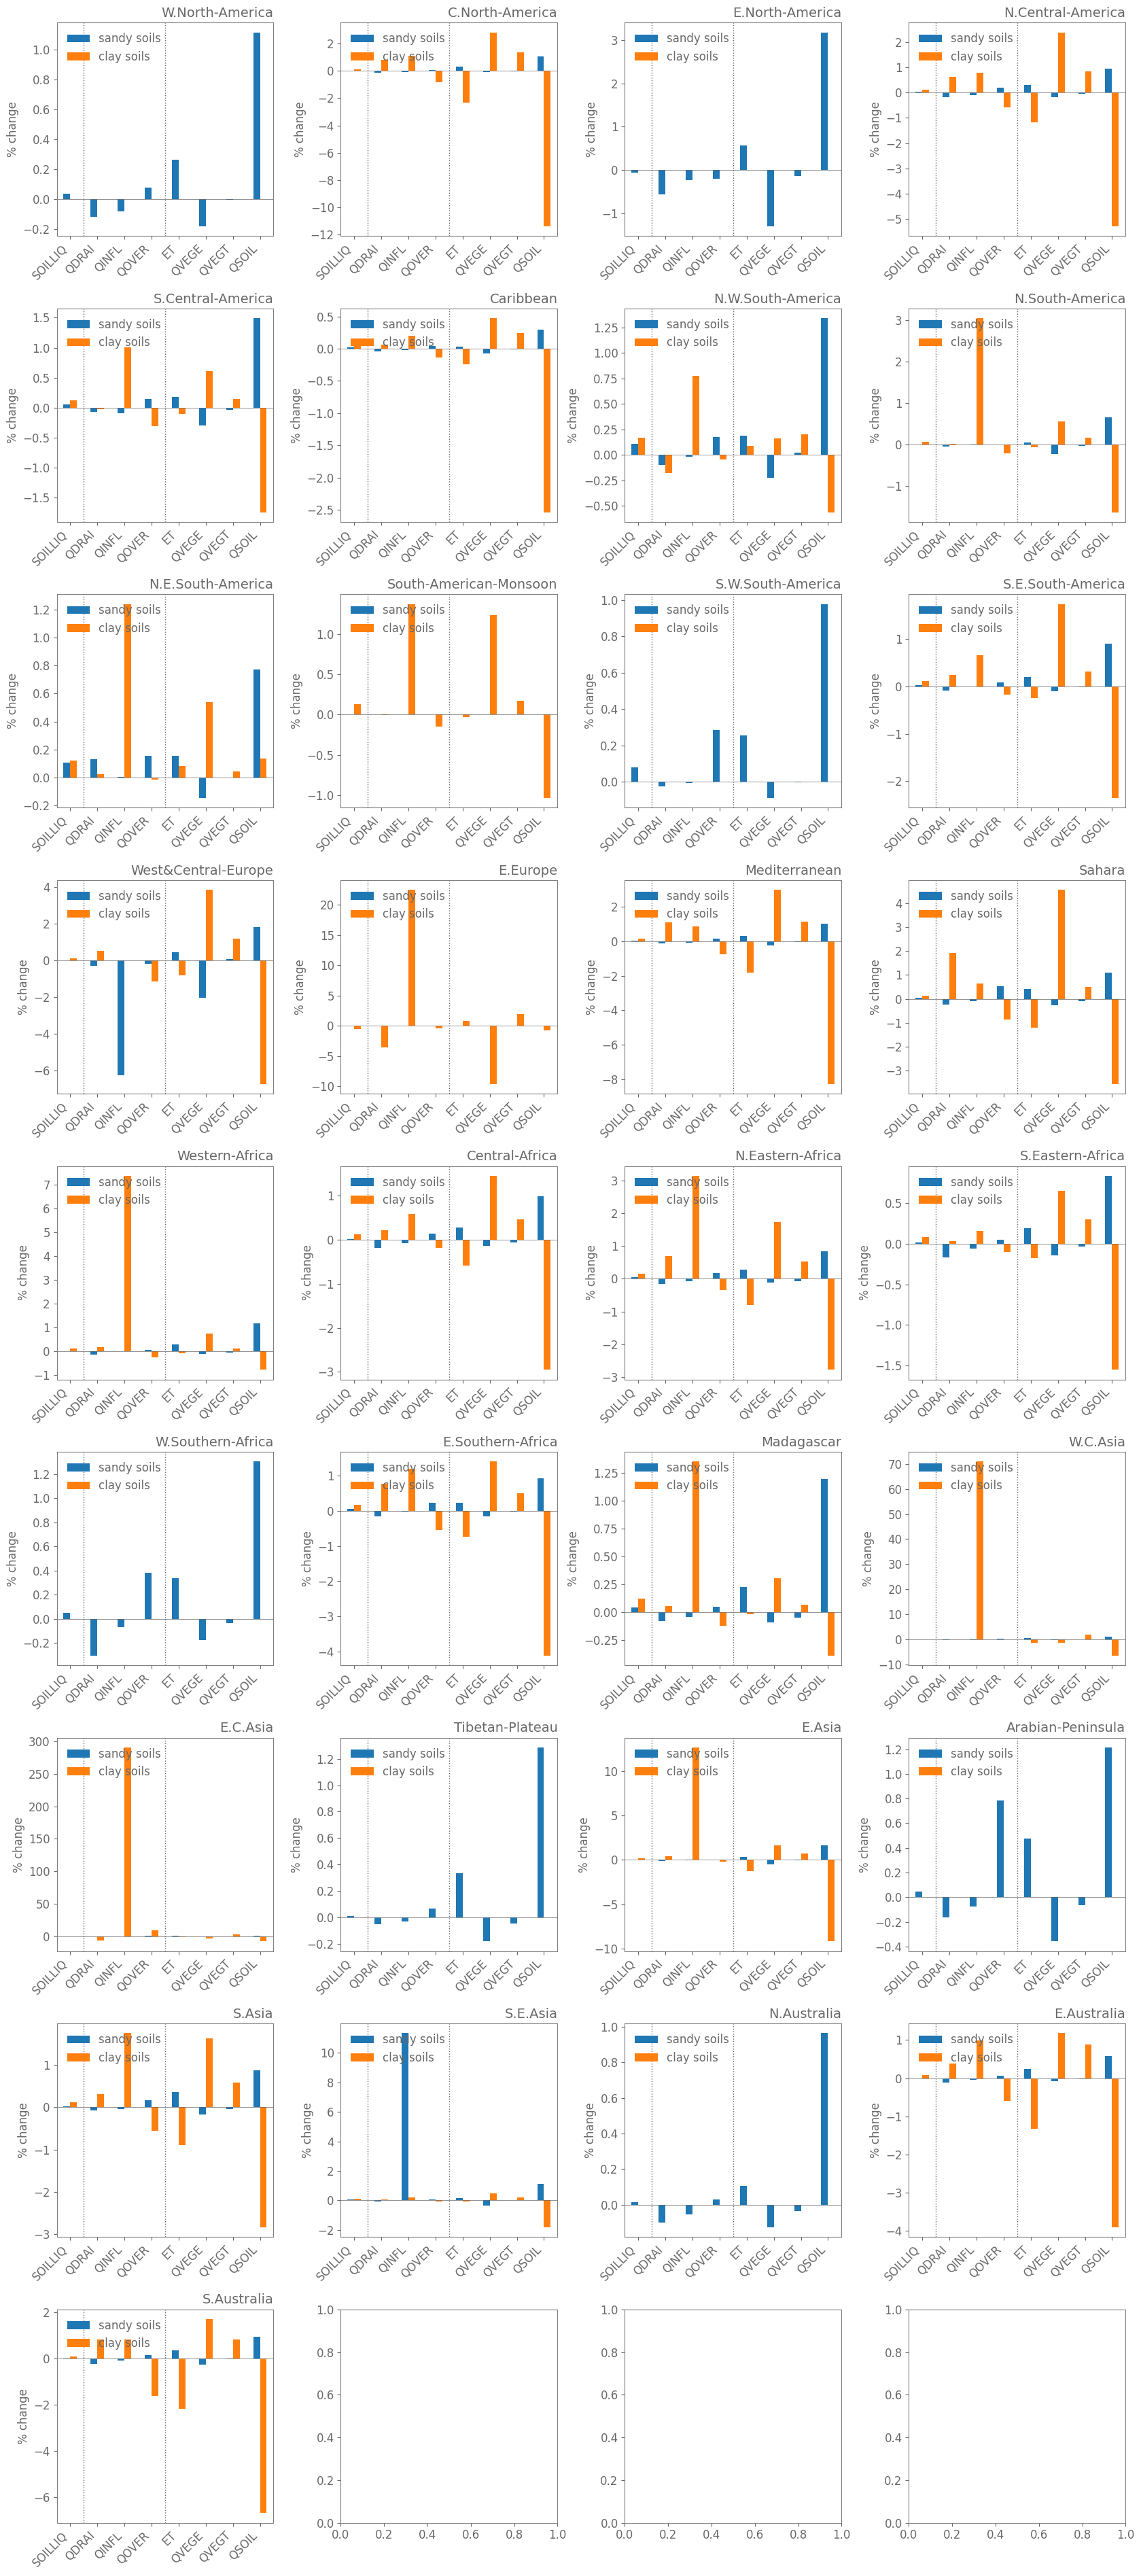

In [20]:
variables_wb        = ['TOTSOILLIQ','QDRAI' , 'QINFL', 'QOVER',  'EFLX_LH_TOT', "QVEGE", "QVEGT","QSOIL"]
variables_wb_toplot = ['SOILLIQ'   , 'QDRAI', 'QINFL', 'QOVER',     'ET'         , "QVEGE", "QVEGT","QSOIL"]


pft_int = pft_list_crops[1]
texture_mask = da_sand_mask.compute()
df_wbterms_sand = calc_wb_terms_pft(variables_wb, variables_wb_toplot, pft_list, case_ctl, stream, start_year, end_year, texture_mask.name, texture_mask, flag_calc_wb=True)[pft_int]
texture_mask = da_clay_mask.compute()
df_wbterms_clay = calc_wb_terms_pft(variables_wb, variables_wb_toplot, pft_list, case_ctl, stream, start_year, end_year, texture_mask.name, texture_mask, flag_calc_wb=True)[pft_int]

region_ids_sand = list(map(int, df_wbterms_sand.loc[:, (df_wbterms_sand.notna().sum()>0)].keys().values))
region_ids_clay = list(map(int, df_wbterms_clay.loc[:, (df_wbterms_clay.notna().sum()>0)].keys().values))
ids_uniques = set(region_ids_clay + region_ids_sand )


fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms_sand.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(ids_uniques):
    
    
    df_wbterms_toplot = pd.DataFrame(df_wbterms_sand.loc[variables_wb_toplot, str(region)]).rename(columns={str(region):'sandy soils'})
    df_wbterms_toplot['clay soils'] = df_wbterms_clay.loc[variables_wb_toplot, str(region)]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    
    df_wbterms_toplot.plot.bar(ax=ax, legend=True)

    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

## Growing season vs non-growing season

In [14]:
GS_text = 'growingseason'

GS_mask = da_growingseason_mask

In [15]:
%%time 

flag_calc_wb = False

if flag_calc_wb:


    pft_list = pft_list_crops

    variables_wb = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'EFLX_LH_TOT',   "QVEGE", "QVEGT","QSOIL", 'QIRRIG_FROM_SURFACE']
    variables_wb_toplot = ['QDRAI', 'QINFL', 'QOVER', 'SOILLIQ', 'ET',  "QVEGE", "QVEGT","QSOIL",  'QIRRIG_FROM_SURFACE']

    d_wb_vars = {}


    for pft_int in pft_list: 
        for i,region in enumerate(region_ids):
            print(region)

            region_name = regionmask.defined_regions.ar6.land[region].name
            region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

            d_var_list = {}

            for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
                print(variable)


                da_delta, da_delta_rel = calc_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list)
                list_da_pft = []

                for pft_int in pft_list: 

                    list_da_pft.append(load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable))

                da_ctl = xr.concat(list_da_pft, dim='ivt_str').rename({'ivt_str':'pft'})
                da_ctl['pft'] = pft_list

                mask = regionmask.defined_regions.ar6.land.mask(da_delta)

                da_delta_timmean = da_delta.where(GS_mask).mean('time')
                da_ctl_timmean = da_ctl.where(GS_mask).mean('time')

                da_ctl_seasmean_region = (da_delta_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon')) / da_ctl_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon'))).values*100

                d_var_list[variable_toplot]= da_ctl_seasmean_region

            d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

        df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
        df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+GS_text+'.nc')

else: 
    d_wbterms = {}
    for pft_int in pft_list: 
        d_wbterms[pft_int] = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+GS_text+'.nc', index_col=0)
    

CPU times: user 6.39 ms, sys: 0 ns, total: 6.39 ms
Wall time: 6.87 ms


#### Non growing season

In [13]:
GS_text = 'non-growingseason'

GS_mask = (-da_growingseason_mask >-1).where(landmask)

In [22]:
df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(15)+'.'+GS_text+'.nc')

In [19]:
procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(15)+'.'+GS_text+'.nc'

'/scratch/snx3000/ivanderk/processing_4p1000/postprocessing/wbterm_delta_per_region_4p1000_15.non-growingseason.nc'

In [23]:
df_wbterms

3         4         5         6         7  \
QDRAI               -0.003000 -0.173578 -0.207720 -0.042992  0.125489   
QINFL                8.336564 -0.165712  0.273643  0.161803 -0.079483   
QOVER               -0.311759 -0.171477 -0.248165  0.276207  0.255999   
SOILLIQ              0.063631  0.031452  0.009373  0.047114  0.128308   
ET                   0.492846  0.294064  0.504222  0.056006  0.141077   
QVEGE               -1.561638  0.130291 -0.366685 -0.062619 -0.094174   
QVEGT                0.161432  0.279540  0.093921  0.208584  0.038662   
QSOIL                0.836916  0.313775  1.230466 -0.138393  0.590882   
QIRRIG_FROM_SURFACE  0.600195  0.682890  1.218492  0.091813  0.324624   

                            8         9        10        11        12  ...  \
QDRAI                0.171549 -0.153014 -0.083120 -0.067081 -0.130620  ...   
QINFL                0.171317 -0.104689  0.379367 -0.104644  0.220390  ...   
QOVER                0.080008  0.167615  0.032307  0.260524  0.250123  ...   
SOILLIQ              0.085972  0.081202  0.042890  0.078782  0.055327  ...   
ET                  -0.134506  0.207578  0.113374  0.279435  0.340765  ...   
QVEGE                0.069552 -0.300779 -0.095500 -0.394062 -0.297742  ...   
QVEGT                0.125366  0.044198  0.018735 -0.078239  0.019877  ...   
QSOIL               -1.076105  1.189506  0.523576  1.275617  1.130435  ...   
QIRRIG_FROM_SURFACE -0.092785  0.336980  0.139110  0.306853  0.430869  ...   

                           34        35        36        37        38  \
QDRAI               -0.082688 -0.056339 -0.251378  0.004271 -0.019743   
QINFL                0.007257 -0.094437 -0.088992  1.030452  0.917129   
QOVER                0.330345 -0.050456  0.424227 -0.027076 -0.027937   
SOILLIQ              0.052451  0.075866  0.030515  0.061832  0.051173   
ET                   0.499955  0.269794  0.428009  0.026202  0.088536   
QVEGE               -0.589001 -0.480585 -0.198334  0.065291 -0.033237   
QVEGT               -0.028013  0.136044 -0.078600  0.052804  0.019007   
QSOIL                1.377596  0.590482  1.010479  0.003244  0.433848   
QIRRIG_FROM_SURFACE  0.578232  0.486701  0.423230  0.038588  0.172296   

                           39  40        41        42        43  
QDRAI               -0.076819 NaN  0.164794 -0.032170  0.277343  
QINFL               -0.061433 NaN  0.319913  0.063570 -0.706633  
QOVER                0.141807 NaN -0.444716 -0.077082 -0.900534  
SOILLIQ              0.023700 NaN  0.050175  0.011634  0.100748  
ET                   0.198627 NaN -0.771574 -0.017854  0.140966  
QVEGE               -0.228986 NaN  0.961738 -0.095631  0.399967  
QVEGT               -0.039585 NaN  0.490860  0.096862  0.336016  
QSOIL                1.321333 NaN -2.038991 -0.137414 -0.418760  
QIRRIG_FROM_SURFACE  0.217800 NaN -0.810615 -0.033809  0.490602  

[9 rows x 36 columns]

In [15]:
%%time 

flag_calc_wb = True

if flag_calc_wb:


    pft_list = pft_list_crops

    variables_wb = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'EFLX_LH_TOT',   "QVEGE", "QVEGT","QSOIL", 'QIRRIG_FROM_SURFACE']
    variables_wb_toplot = ['QDRAI', 'QINFL', 'QOVER', 'SOILLIQ', 'ET',  "QVEGE", "QVEGT","QSOIL",  'QIRRIG_FROM_SURFACE']

    d_wb_vars = {}


    for pft_int in pft_list: 
        print(pft_int)
        for i,region in enumerate(region_ids):
            print(region)

            region_name = regionmask.defined_regions.ar6.land[region].name
            region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

            d_var_list = {}

            for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
                print(variable)


                da_delta, da_delta_rel = calc_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list)
                list_da_pft = []

                for pft_int in pft_list: 

                    list_da_pft.append(load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable))

                da_ctl = xr.concat(list_da_pft, dim='ivt_str').rename({'ivt_str':'pft'})
                da_ctl['pft'] = pft_list

                mask = regionmask.defined_regions.ar6.land.mask(da_delta)

                da_delta_timmean = da_delta.where(GS_mask).mean('time')
                da_ctl_timmean = da_ctl.where(GS_mask).mean('time')

                da_ctl_seasmean_region = (da_delta_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon')) / da_ctl_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon'))).values*100

                d_var_list[variable_toplot]= da_ctl_seasmean_region

            d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

        df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
        print("saving WB terms for "+str(pft_int))
        df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+GS_text+'.nc')

else: 
    d_wbterms_growingseason = {}
    for pft_int in pft_list: 
        d_wbterms_growingseason[pft_int] = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+GS_text+'.nc', index_col=0)
    

15
3
QDRAI
QINFL
QOVER


KeyboardInterrupt: 

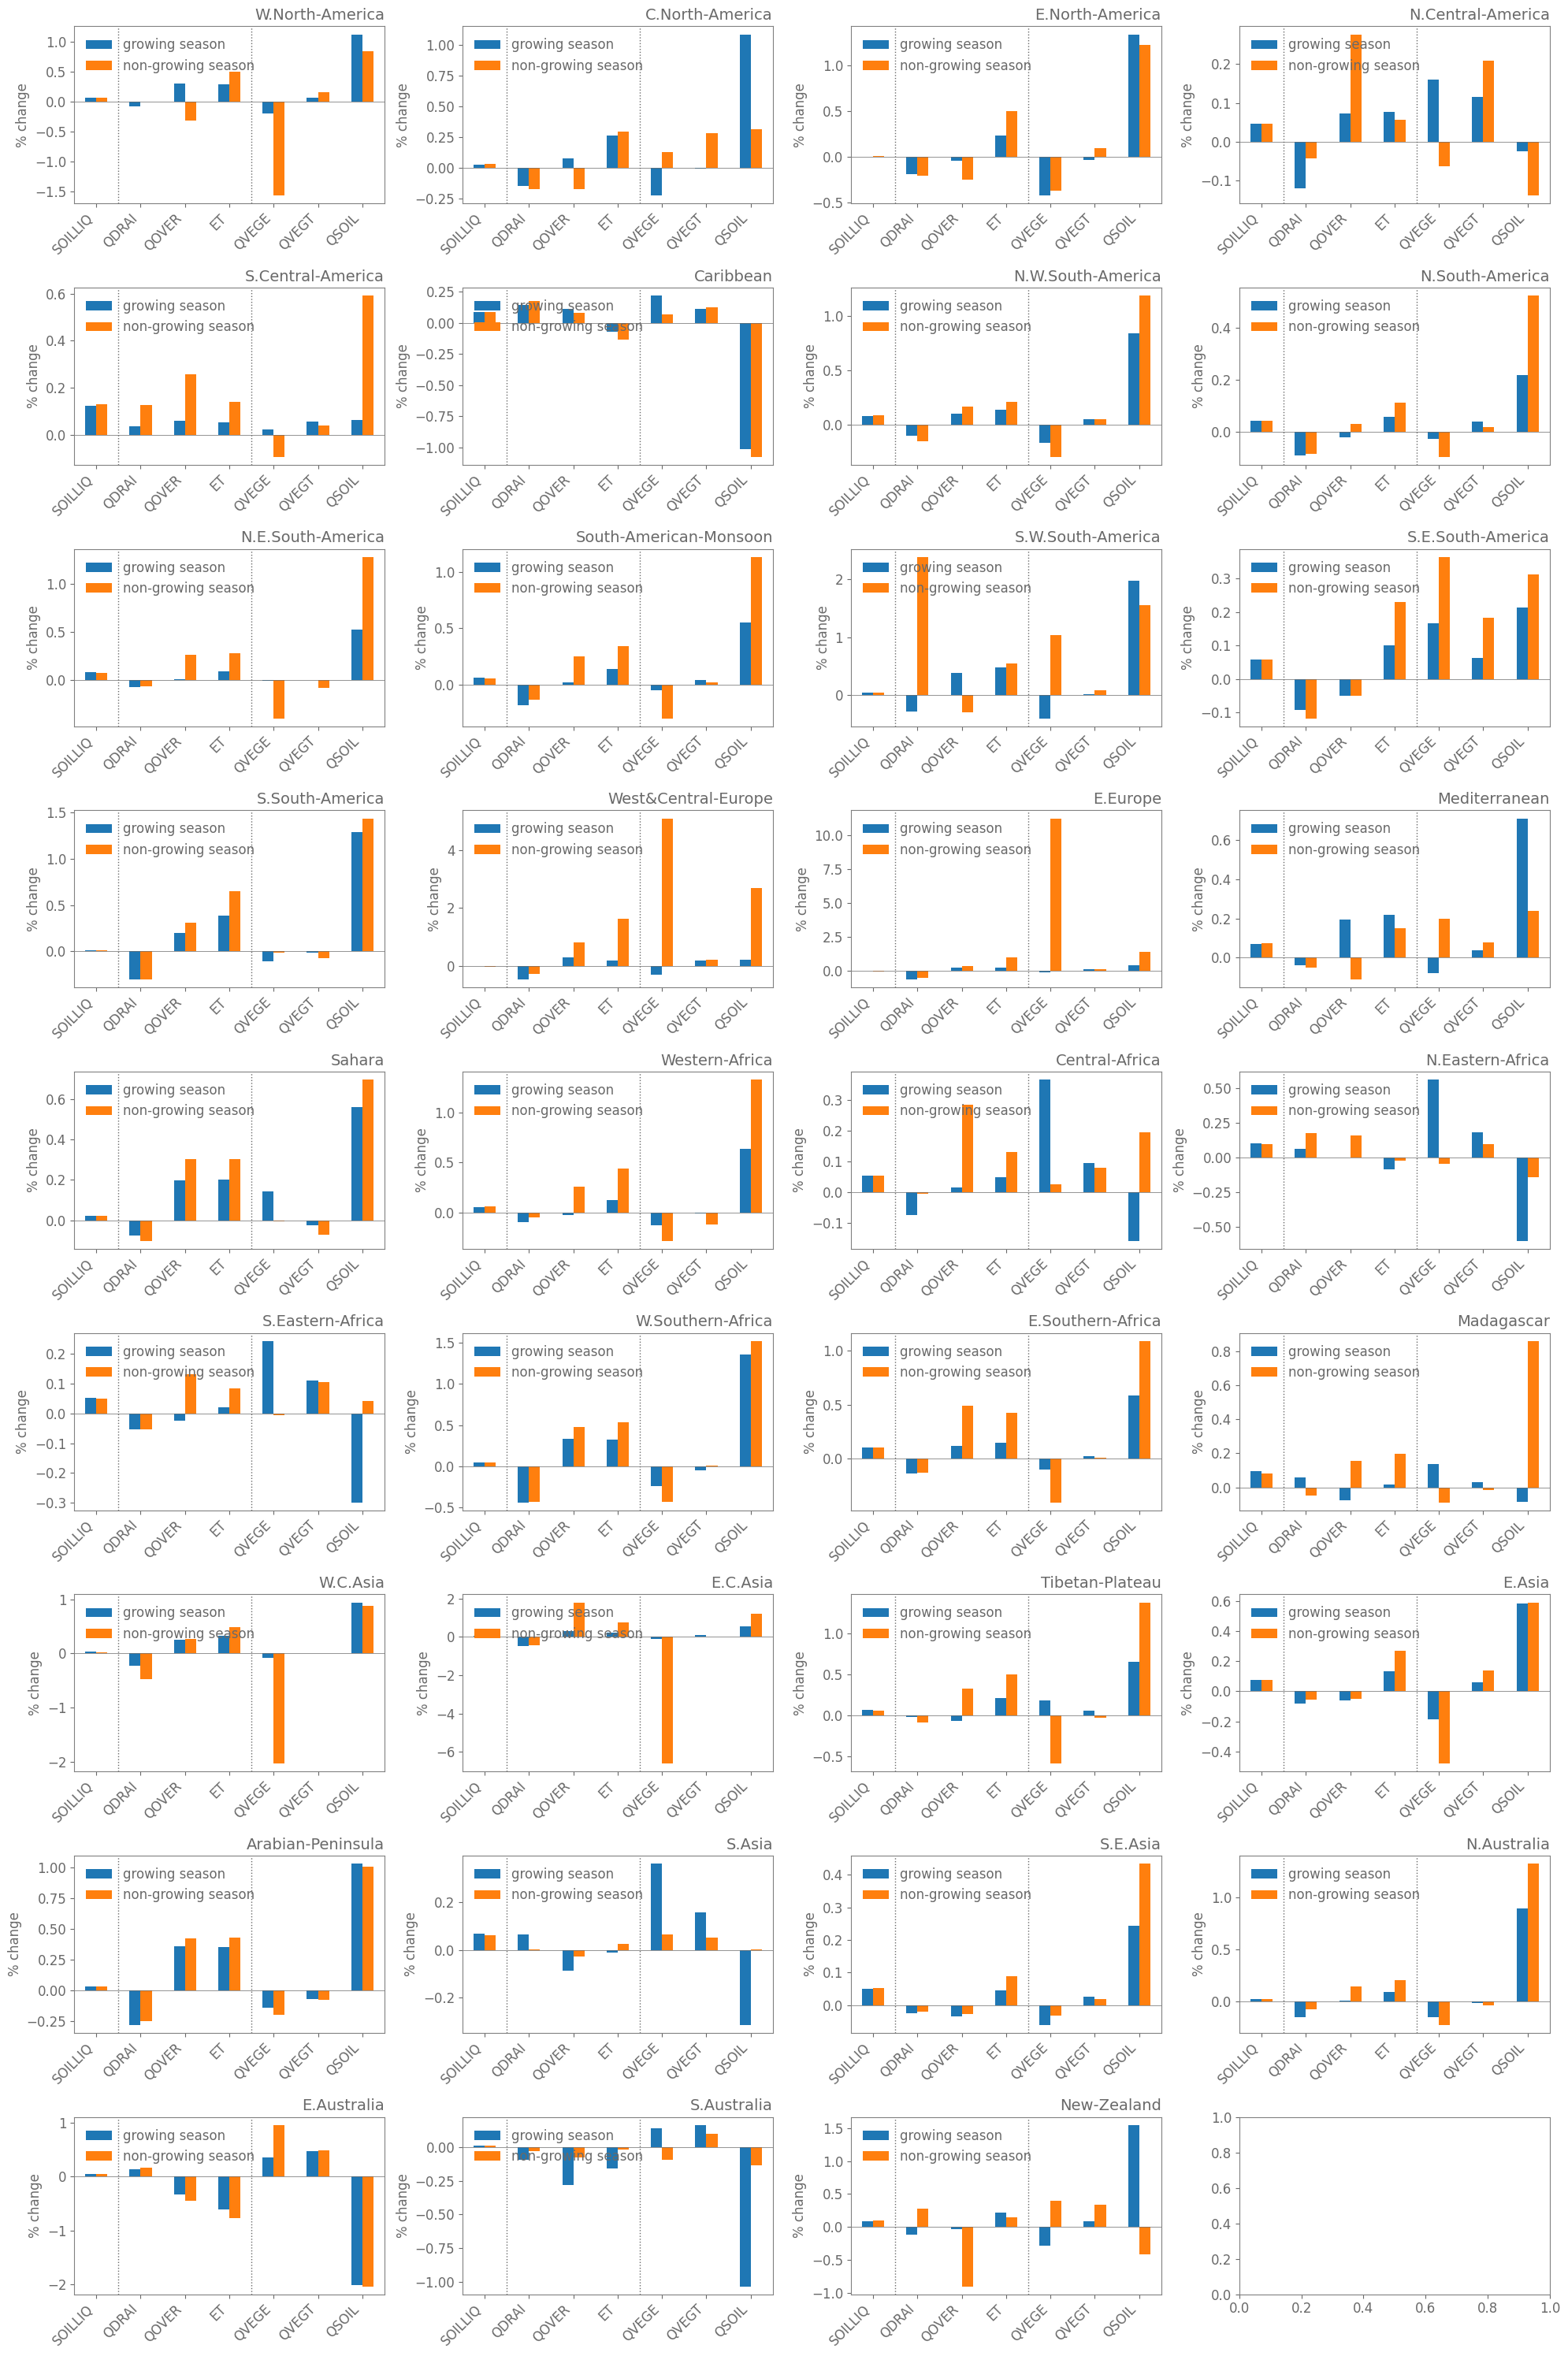

In [22]:
variables_wb_toplot = ['SOILLIQ','QDRAI', 'QOVER',  'ET', 'QVEGE', 'QVEGT', 'QSOIL']
figsize = (20,30)


pft_int = pft_list_crops[0]

df_wbterms_growingseason = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+'growingseason'+'.nc', index_col=0)
df_wbterms_non_growingseason = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+'non-growingseason'+'.nc', index_col=0)

region_ids_growingseason = list(map(int, df_wbterms_growingseason.loc[:, (df_wbterms_growingseason.notna().sum()>0)].keys().values))
region_ids_non_growingseason = list(map(int, df_wbterms_non_growingseason.loc[:, (df_wbterms_non_growingseason.notna().sum()>0)].keys().values))
ids_uniques = set(region_ids_non_growingseason + region_ids_growingseason )


fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms_growingseason.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(ids_uniques):
    
    
    df_wbterms_toplot = pd.DataFrame(df_wbterms_growingseason.loc[variables_wb_toplot, str(region)]).rename(columns={str(region):'growing season'})
    df_wbterms_toplot['non-growing season'] = df_wbterms_non_growingseason.loc[variables_wb_toplot, str(region)]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    
    df_wbterms_toplot.plot.bar(ax=ax, legend=True)

    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

## sandy soils

In [18]:
texture_mask = da_sand_mask.compute()
texture_name = texture_mask.name

In [16]:
%%time 

flag_calc_wb = False

if flag_calc_wb:


    pft_list = pft_list_crops

    variables_wb = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'EFLX_LH_TOT',   "QVEGE", "QVEGT","QSOIL", 'QIRRIG_FROM_SURFACE']
    variables_wb = ['TSA']

    variables_wb_toplot = ['QDRAI', 'QINFL', 'QOVER', 'SOILLIQ', 'ET',  "QVEGE", "QVEGT","QSOIL",  'QIRRIG_FROM_SURFACE']

    d_wb_vars = {}


    for pft_int in pft_list: 
        for i,region in enumerate(region_ids):
            print(region)

            region_name = regionmask.defined_regions.ar6.land[region].name
            region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

            d_var_list = {}

            for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
                print(variable)


                da_delta, da_delta_rel = calc_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list)
                list_da_pft = []

                for pft_int in pft_list: 

                    list_da_pft.append(load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable))

                da_ctl = xr.concat(list_da_pft, dim='ivt_str').rename({'ivt_str':'pft'})
                da_ctl['pft'] = pft_list

                mask = regionmask.defined_regions.ar6.land.mask(da_delta)

                da_delta_timmean = (da_delta).mean('time').where(texture_mask) 
                da_ctl_timmean = da_ctl.mean('time').where(texture_mask)

                da_ctl_seasmean_region = (da_delta_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon')) / da_ctl_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon'))).values*100

                d_var_list[variable_toplot]= da_ctl_seasmean_region

            d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

            df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
            #df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'.nc')

else: 
    d_wbterms = {}
    for pft_int in pft_list: 
        d_wbterms[pft_int] = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'.nc', index_col=0)
    

CPU times: user 5.4 ms, sys: 4.08 ms, total: 9.48 ms
Wall time: 57.1 ms


## CLAY

In [11]:
texture_mask = da_clay_mask.compute()
texture_name = texture_mask.name

In [12]:
%%time 

flag_calc_wb = True

if flag_calc_wb:


    pft_list = pft_list_crops

    variables_wb = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'EFLX_LH_TOT',   "QVEGE", "QVEGT","QSOIL" , 'QIRRIG_FROM_SURFACE']
    variables_wb_toplot = ['QDRAI', 'QINFL', 'QOVER', 'SOILLIQ', 'ET',  "QVEGE", "QVEGT","QSOIL",  'QIRRIG_FROM_SURFACE']

    d_wb_vars = {}


    for pft_int in pft_list: 
        for i,region in enumerate(region_ids):
            print(region)

            region_name = regionmask.defined_regions.ar6.land[region].name
            region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

            d_var_list = {}

            for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
                print(variable)


                da_delta, da_delta_rel = calc_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list)
                list_da_pft = []

                for pft_int in pft_list: 

                    list_da_pft.append(load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable))

                da_ctl = xr.concat(list_da_pft, dim='ivt_str').rename({'ivt_str':'pft'})
                da_ctl['pft'] = pft_list

                mask = regionmask.defined_regions.ar6.land.mask(da_delta)

                da_delta_timmean = (da_delta).mean('time').where(texture_mask) 
                da_ctl_timmean = da_ctl.mean('time').where(texture_mask)

                da_ctl_seasmean_region = (da_delta_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon')) / da_ctl_timmean.sel(pft=pft_int).where(mask==region).mean(dim=('lat','lon'))).values*100

                d_var_list[variable_toplot]= da_ctl_seasmean_region

            d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

            df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
            df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'.nc')

else: 
    d_wbterms = {}
    for pft_int in pft_list: 
        d_wbterms[pft_int] = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.'+texture_name+'.nc', index_col=0)
    

3
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
4
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
5
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
6
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
7
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
8
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
9
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
10
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
11
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
12
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
13
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
14
QDRAI
QINFL
QOVER
TOTSOILLIQ
EFLX_LH_TOT
QVEGE
QVEGT
QSOIL
QIRRIG_FROM_SURFACE
15
QDRAI
QINFL
QOVER
TO

KeyboardInterrupt: 

NameError: name 'df_wbterms' is not defined

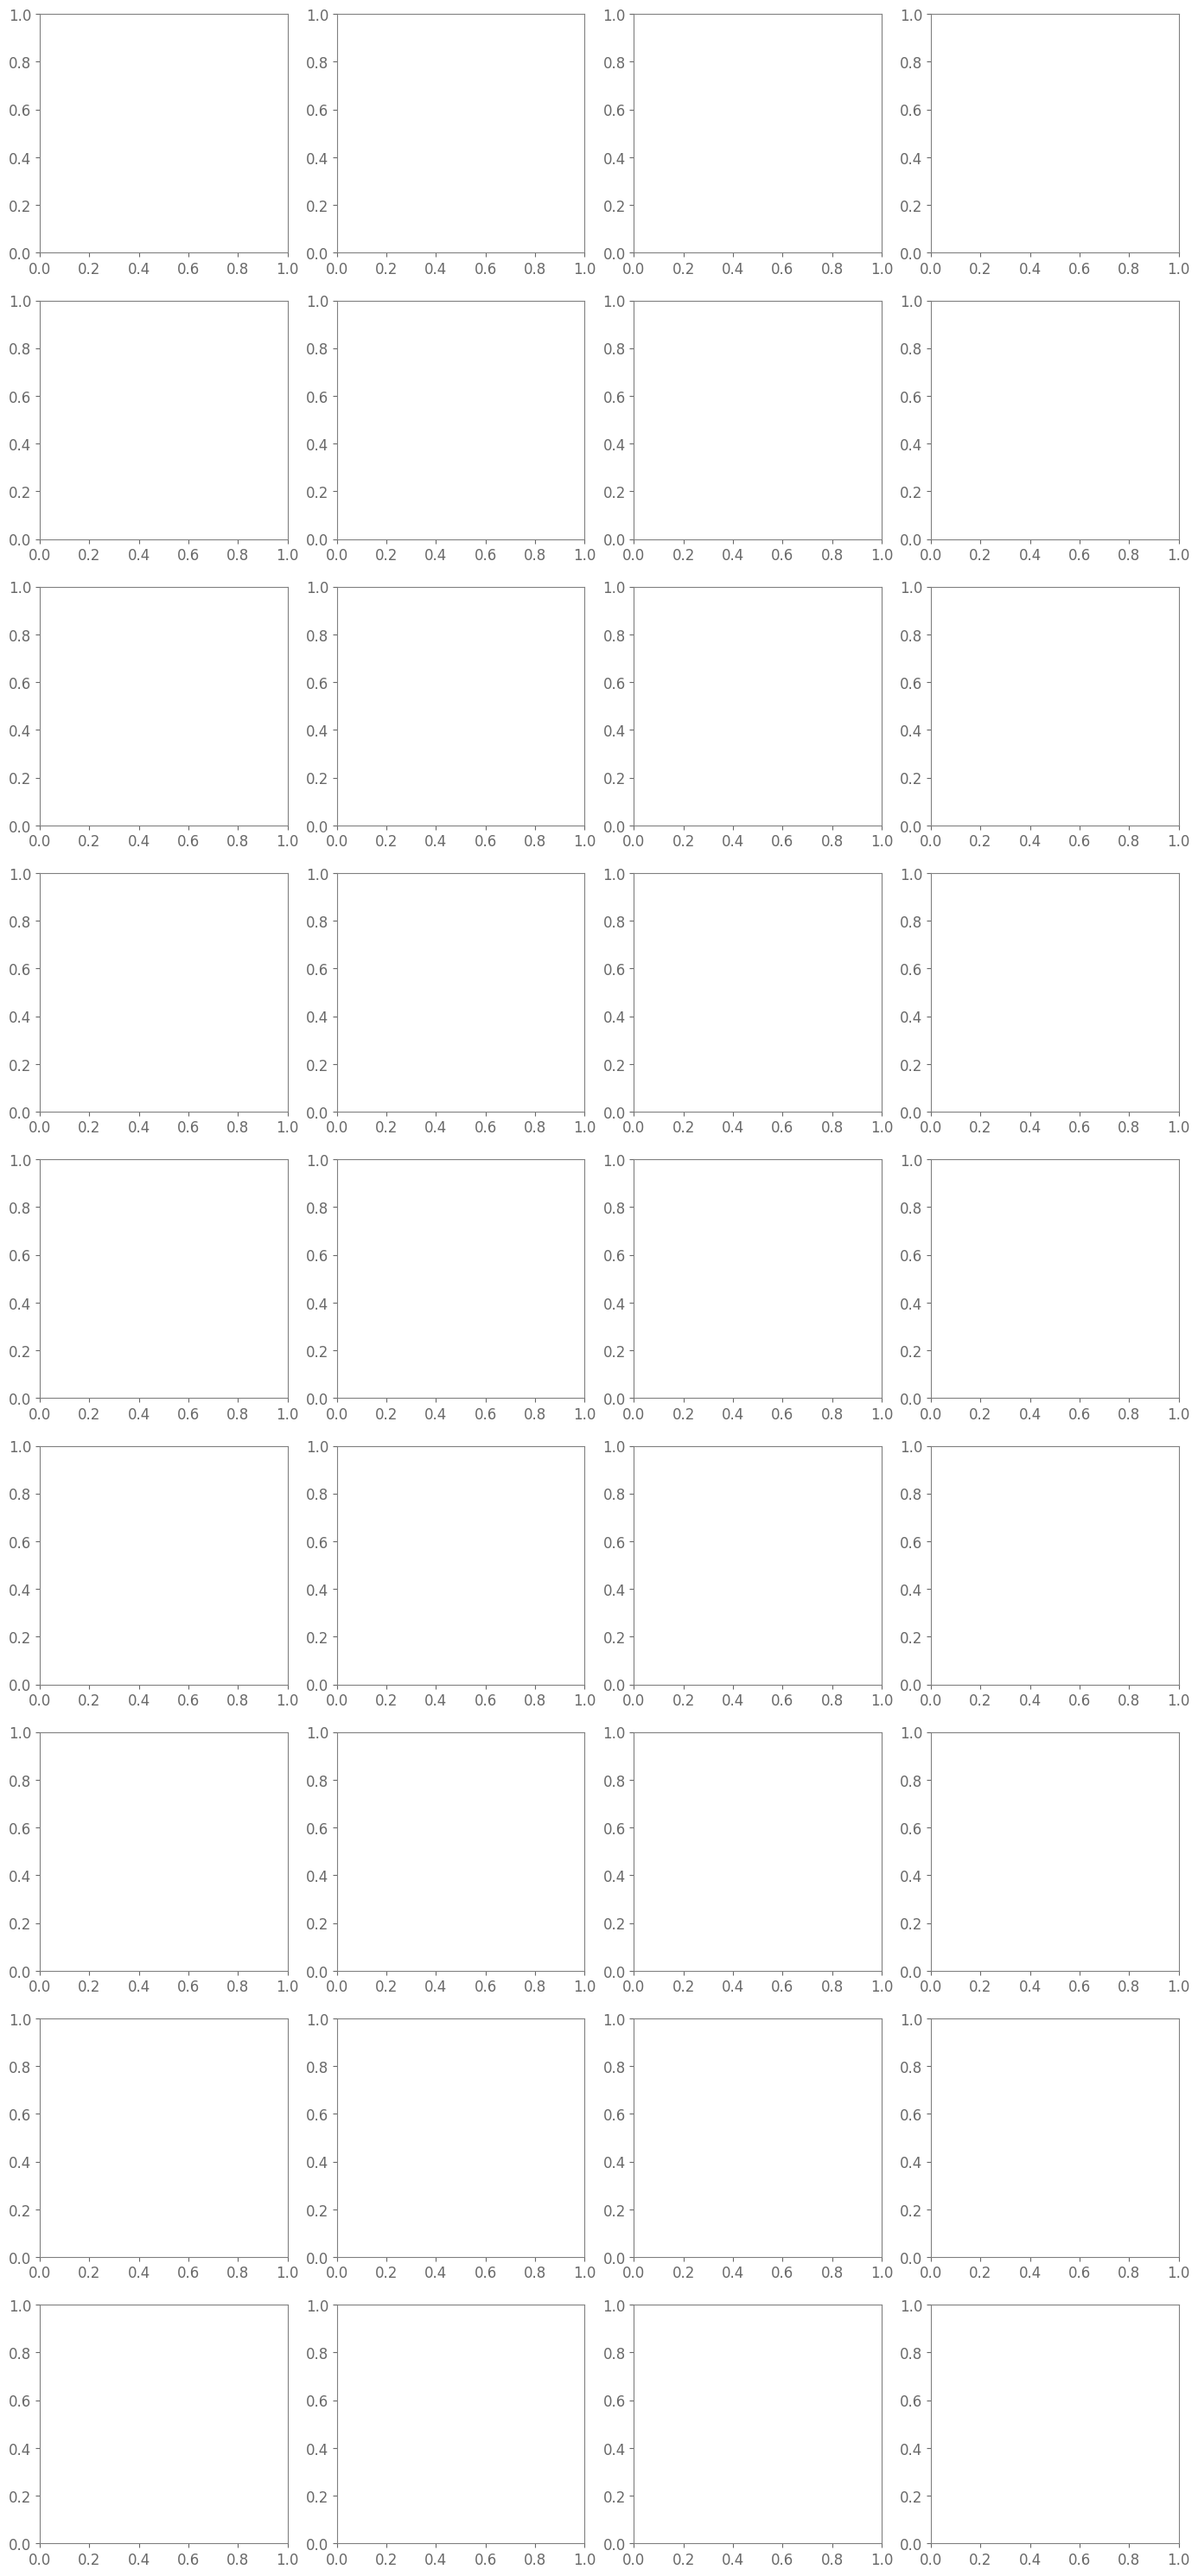

In [24]:
variables_wb_toplot = ['SOILLIQ','QDRAI', 'QOVER',  'ET', 'QVEGE', 'QVEGT', 'QSOIL']

pft_int = pft_list_crops[0]
fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(region_ids):
    
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    df_wbterms.loc[variables_wb_toplot, str(region)].plot.bar(ax=ax, legend=False)
    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')

    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

## Clay and sand together

### NOT IRRIGATED

In [14]:
df_wbterms_sand

3   4         5   6   7   8         9        10        11  \
SOILLIQ  0.254678 NaN -0.211969 NaN NaN NaN  0.014369  0.010267 -0.028309   
QDRAI    2.282690 NaN -0.983806 NaN NaN NaN -0.008975 -0.130778 -0.316493   
QINFL   -2.039269 NaN -0.028528 NaN NaN NaN  4.111149  4.194047 -0.135503   
QOVER   -2.198840 NaN -0.297847 NaN NaN NaN -0.009524 -0.109866 -0.024311   
ET       0.183907 NaN  0.527317 NaN NaN NaN  0.010941  0.108882  0.050636   
QVEGE   -0.451664 NaN -1.343445 NaN NaN NaN -0.059890 -0.367993 -0.265362   
QVEGT   -0.179216 NaN -0.171600 NaN NaN NaN -0.021197 -0.024900 -0.027353   
QSOIL    1.705496 NaN  4.365295 NaN NaN NaN  0.267159  1.089189  0.642393   

               12  ...        34        35        36        37        38  \
SOILLIQ  0.016485  ... -0.002136 -0.044862  0.008600 -0.012313  0.036109   
QDRAI   -0.160697  ... -0.025682 -0.120117 -0.899740 -0.033886 -0.053720   
QINFL    0.194461  ... -0.046467 -0.091481  5.313484 -0.014065  1.944174   
QOVER   -0.123961  ... -0.001118 -0.013217  0.000103 -0.000822 -0.036308   
ET       0.092641  ...  0.015201  0.067731  0.001901  0.019134  0.051530   
QVEGE   -0.230940  ... -0.021487 -0.055003 -0.028607 -0.007803 -0.260118   
QVEGT   -0.010815  ... -0.041518 -0.039914 -0.120866 -0.011994  0.004402   
QSOIL    0.823918  ...  0.201383  0.515835  0.235938  0.108633  0.708563   

               39          40        41        42        43  
SOILLIQ -0.015228   -0.021889 -0.068142 -0.133269  0.112446  
QDRAI   -0.176642 -113.132495 -4.915359 -4.467885 -0.114833  
QINFL   -0.426815   -0.775904 -1.119244 -5.744897 -2.208454  
QOVER   -0.060475   -0.000173 -0.189041 -0.292582 -0.039512  
ET       0.058756    0.354514  0.340711  0.432422  0.111630  
QVEGE   -0.176337   -0.105398 -1.353159 -0.776204 -0.230394  
QVEGT   -0.094901   -0.188138 -0.733034 -0.291012 -0.081725  
QSOIL    0.543868    1.705584  4.063244  3.784840  1.799014  

[8 rows x 36 columns]

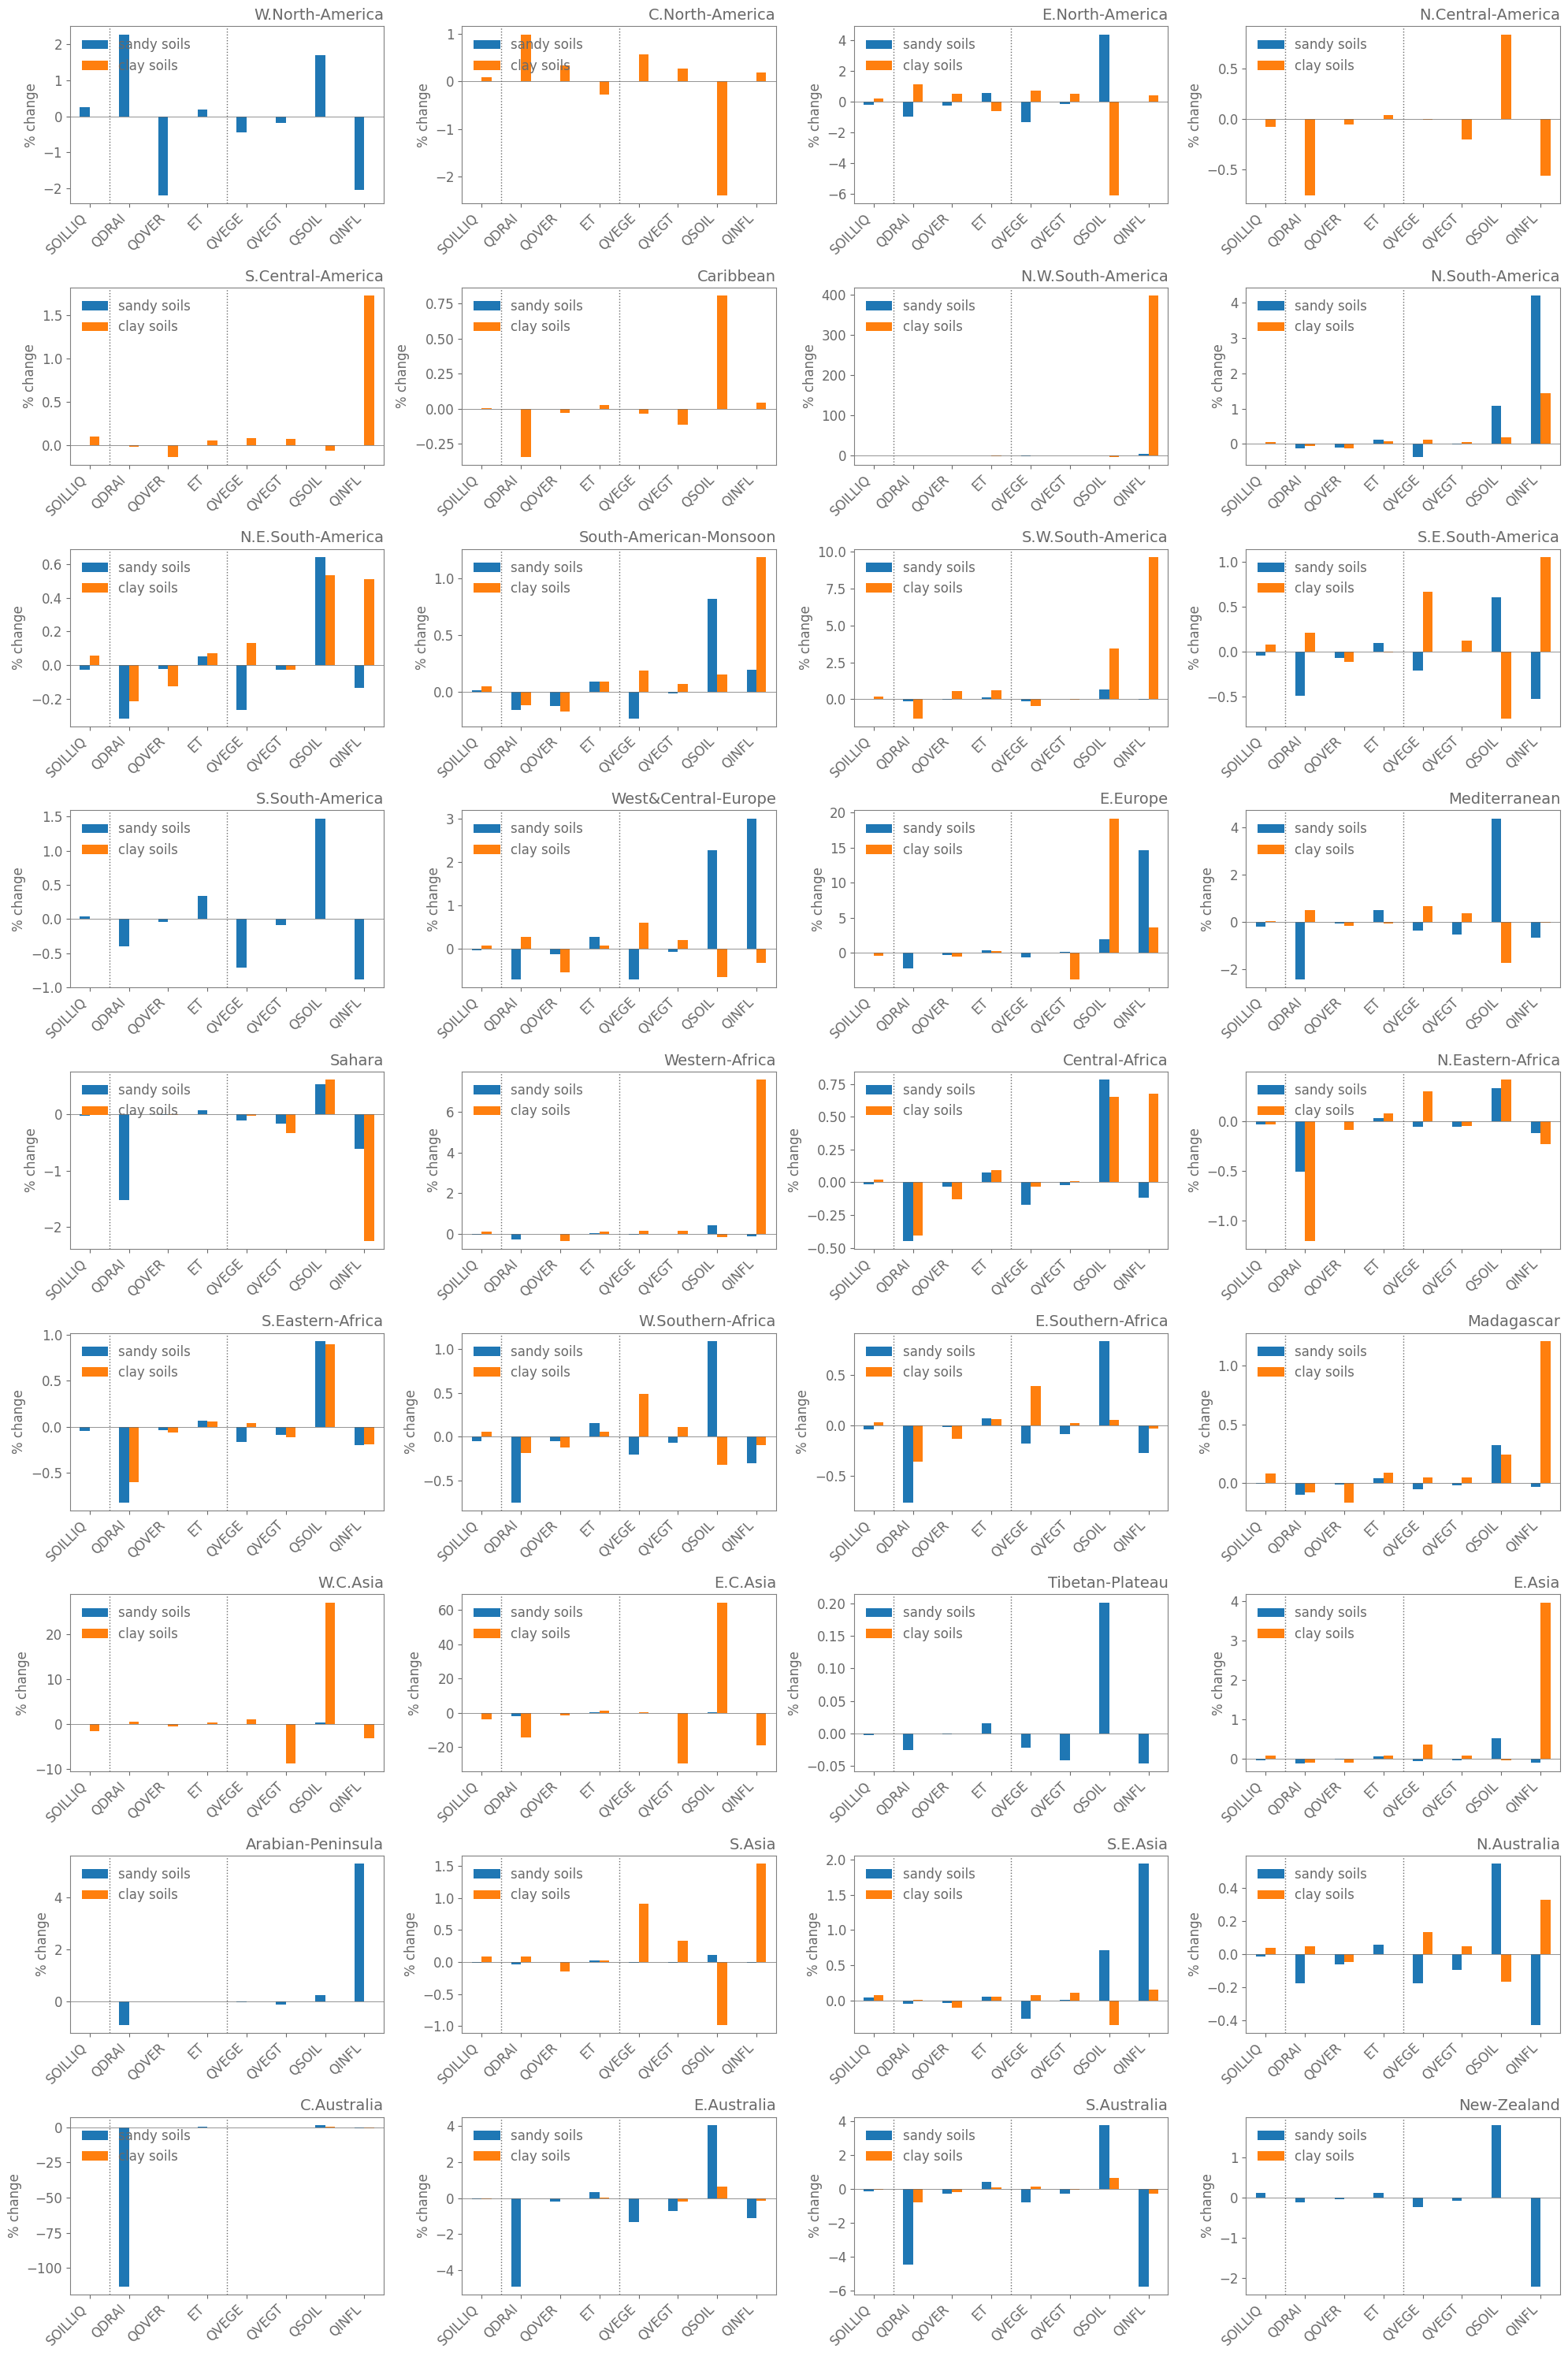

In [15]:
variables_wb_toplot = ['SOILLIQ','QDRAI', 'QOVER',  'ET', 'QVEGE', 'QVEGT', 'QSOIL',  "QINFL"]
figsize = (20,30)


pft_int = pft_list_crops[0]

df_wbterms_sand = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.PCT_SAND.nc', index_col=0)
df_wbterms_clay = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.PCT_CLAY.nc', index_col=0)

region_ids_sand = list(map(int, df_wbterms_sand.loc[:, (df_wbterms_sand.notna().sum()>0)].keys().values))
region_ids_clay = list(map(int, df_wbterms_clay.loc[:, (df_wbterms_clay.notna().sum()>0)].keys().values))
ids_uniques = set(region_ids_clay + region_ids_sand )


fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms_sand.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(ids_uniques):
    
    
    df_wbterms_toplot = pd.DataFrame(df_wbterms_sand.loc[variables_wb_toplot, str(region)]).rename(columns={str(region):'sandy soils'})
    df_wbterms_toplot['clay soils'] = df_wbterms_clay.loc[variables_wb_toplot, str(region)]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    
    df_wbterms_toplot.plot.bar(ax=ax, legend=True)

    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

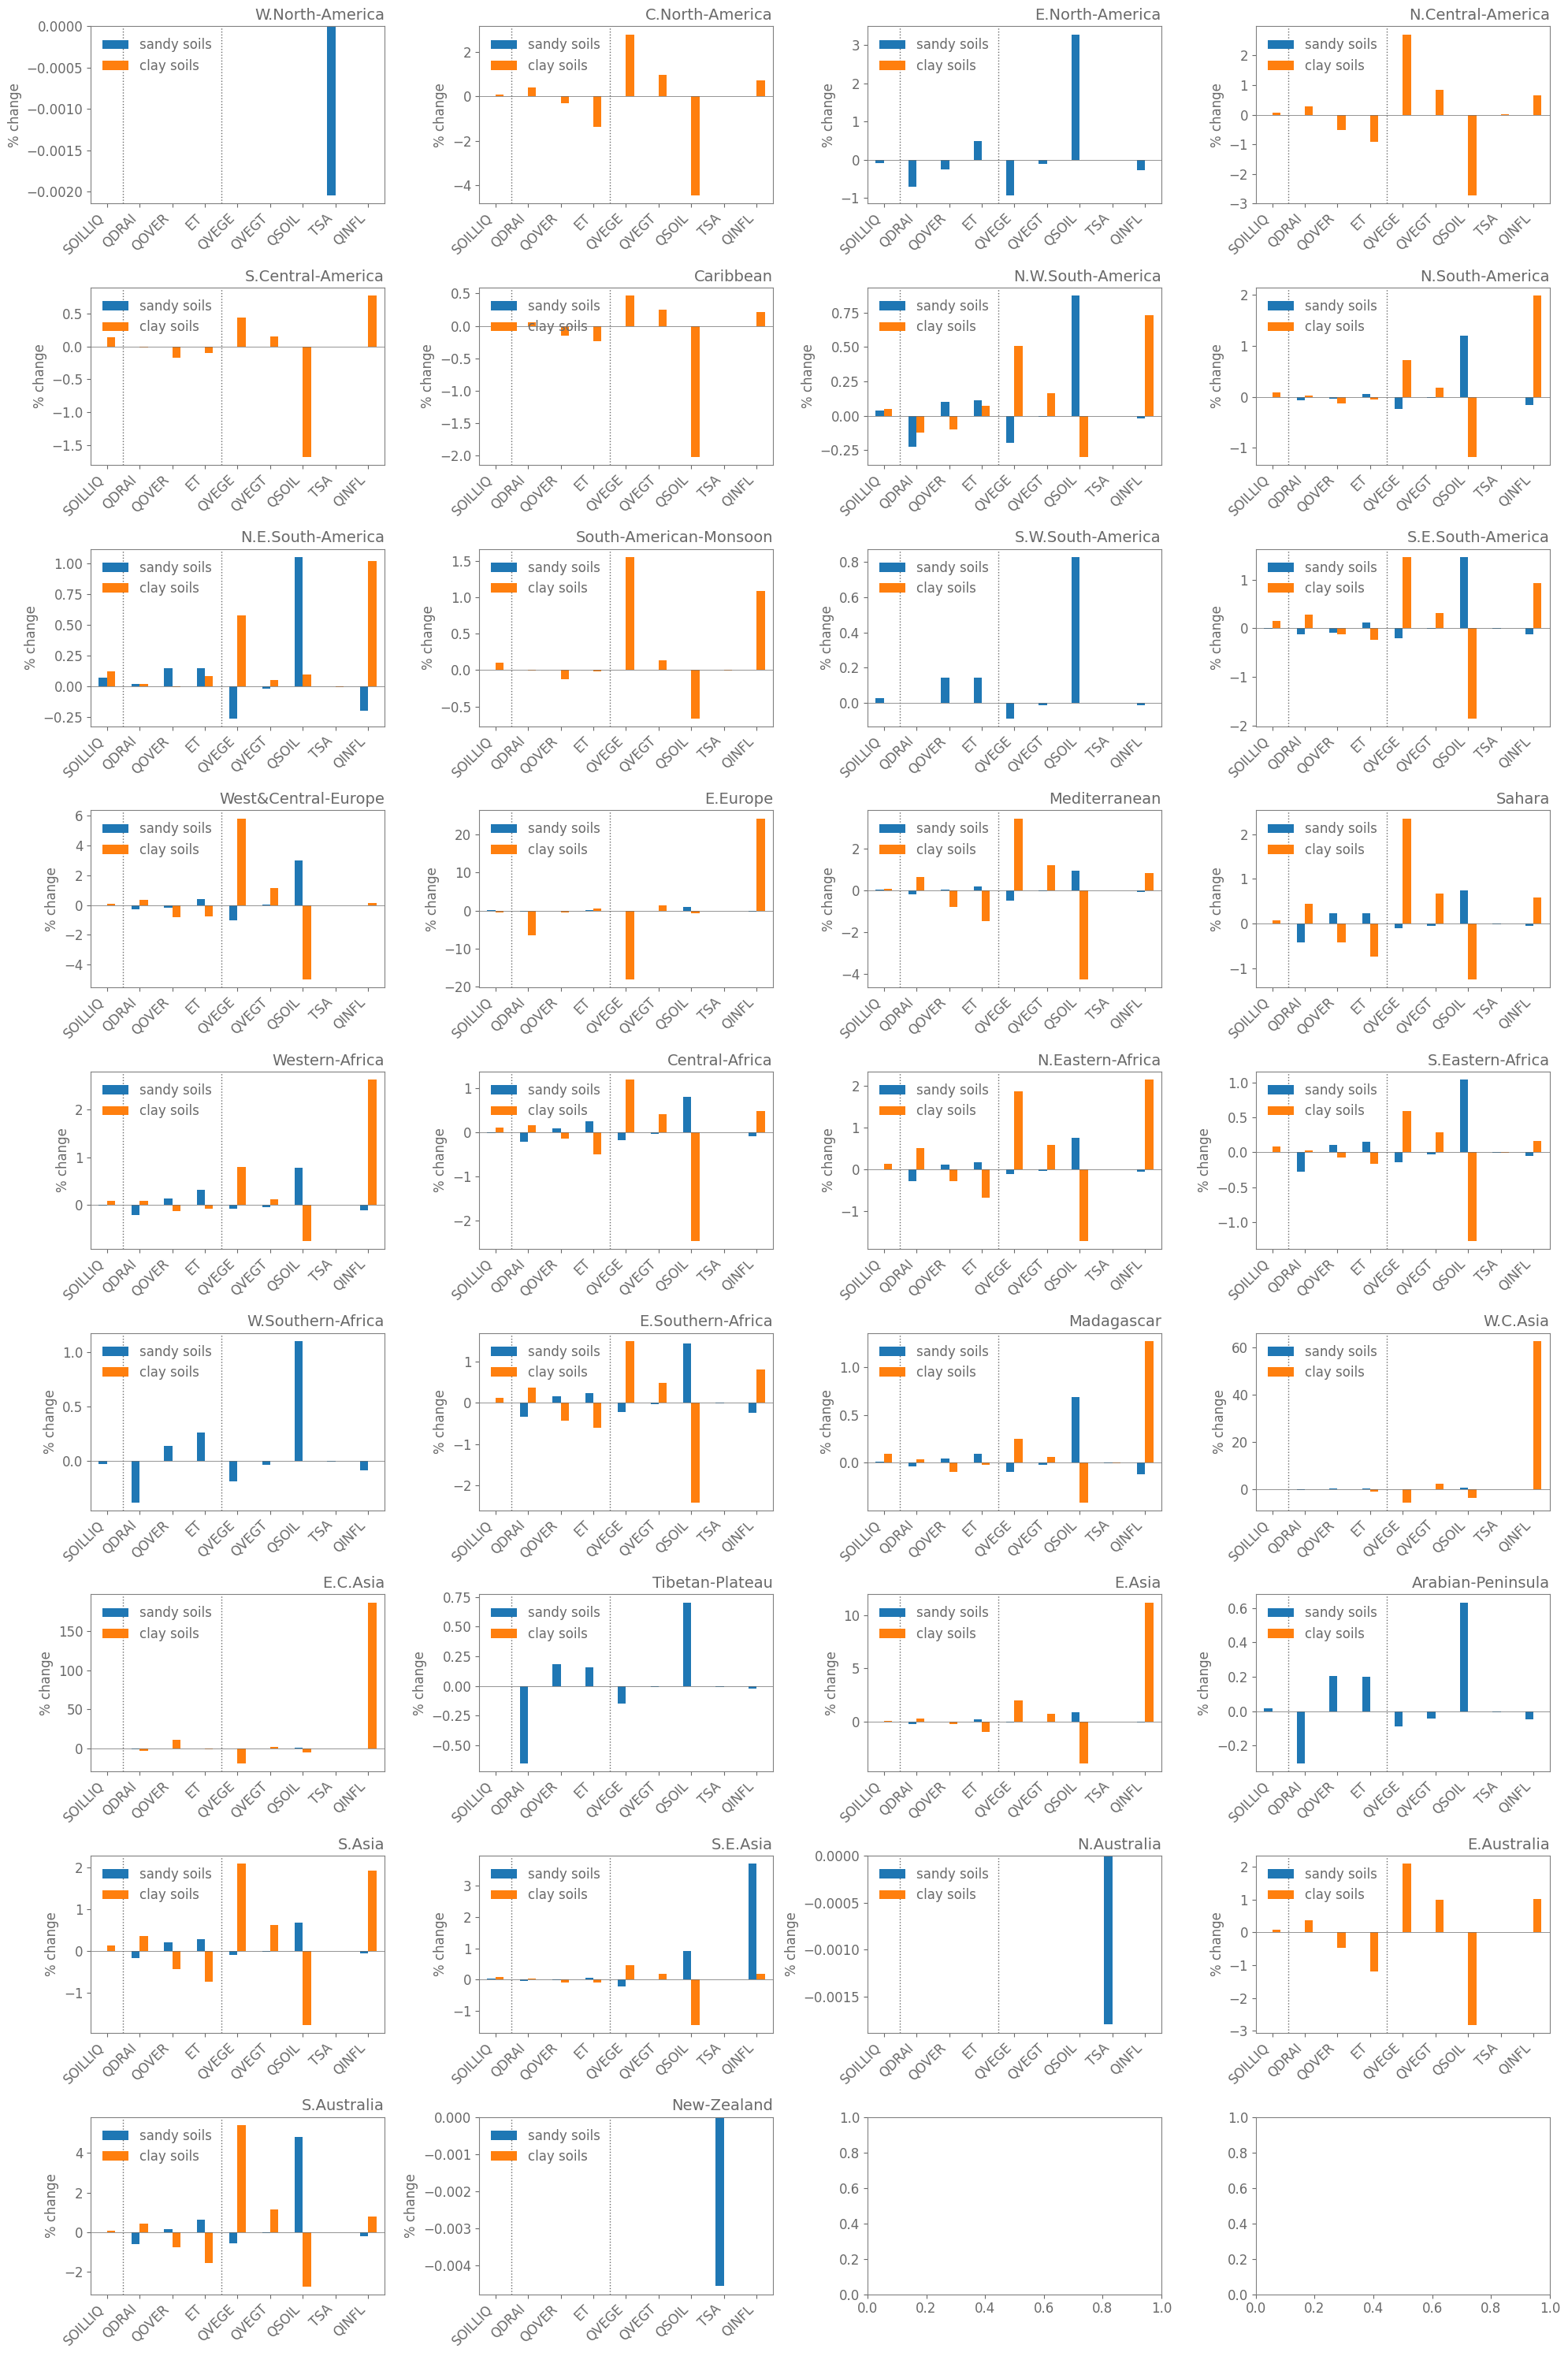

In [8]:
variables_wb_toplot = ['SOILLIQ','QDRAI', 'QOVER',  'ET', 'QVEGE', 'QVEGT', 'QSOIL', "TSA", "QINFL"]
figsize = (20,30)


pft_int = pft_list_crops[0]

df_wbterms_sand = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.PCT_SAND.nc', index_col=0)
df_wbterms_clay = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.PCT_CLAY.nc', index_col=0)

region_ids_sand = list(map(int, df_wbterms_sand.loc[:, (df_wbterms_sand.notna().sum()>0)].keys().values))
region_ids_clay = list(map(int, df_wbterms_clay.loc[:, (df_wbterms_clay.notna().sum()>0)].keys().values))
ids_uniques = set(region_ids_clay + region_ids_sand )


fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms_sand.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(ids_uniques):
    
    
    df_wbterms_toplot = pd.DataFrame(df_wbterms_sand.loc[variables_wb_toplot, str(region)]).rename(columns={str(region):'sandy soils'})
    df_wbterms_toplot['clay soils'] = df_wbterms_clay.loc[variables_wb_toplot, str(region)]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    
    df_wbterms_toplot.plot.bar(ax=ax, legend=True)

    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_toplot), rotation=45, ha='right')

fig.tight_layout()

### IRRIGATED

In [ ]:
variables_wb_toplot = ['SOILLIQ','QDRAI', 'QOVER',  'ET', 'QVEGE', 'QVEGT', 'QSOIL', 'QIRRIG_FROM_SURFACE']
variables_wb_labels = ['SOILLIQ','QDRAI', 'QOVER',  'ET', 'QVEGE', 'QVEGT', 'QSOIL', 'QIRRIG']
figsize = (20,30)


pft_int = pft_list_crops[1]

df_wbterms_sand = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.PCT_SAND.nc', index_col=0)
df_wbterms_clay = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'_'+str(pft_int)+'.PCT_CLAY.nc', index_col=0)

region_ids_sand = list(map(int, df_wbterms_sand.loc[:, (df_wbterms_sand.notna().sum()>0)].keys().values))
region_ids_clay = list(map(int, df_wbterms_clay.loc[:, (df_wbterms_clay.notna().sum()>0)].keys().values))
ids_uniques = set(region_ids_clay + region_ids_sand )


fig, axes = plt.subplots(8,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms_sand.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(ids_uniques):
    
    
    df_wbterms_toplot = pd.DataFrame(df_wbterms_sand.loc[variables_wb_toplot, str(region)]).rename(columns={str(region):'sandy soils'})
    df_wbterms_toplot['clay soils'] = df_wbterms_clay.loc[variables_wb_toplot, str(region)]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    
    df_wbterms_toplot.plot.bar(ax=ax, legend=True)

    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=6.5, color='dimgray', linewidth=1, linestyle = 'dotted')

    ax.legend(loc='upper left', frameon=False)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_labels), rotation=45, ha='right')

fig.tight_layout()